In [1]:
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import sys
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json

In [2]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [3]:
dt_string = 'normal_cycle_female_23062020_140612_'
normalization = 'mean'
signal_type = "signal_norm" #'signal_norm'  
analysis_condition = ''


In [4]:
# Load the data
basedir = r'\\172.25.144.34\LabCommon\Ken\data\2pImaging\result\result_pickle' # folder containing code and data
populationdata = np.load(os.path.join(basedir, 'normal_cycle_female_23062020_140612_Alignedtotrial_meansignal_norm_sucrose_low_high estrogen.npy'),allow_pickle = True)
print(str(populationdata.shape[0])+" cells were analyzed")

143 cells were analyzed


In [25]:
fname = '43384-1 400pwr 1104um 16x obj water-004'
fdir = r'D:\bruker_data\Sean\43384-1 400pwr 1104um 16x obj water-004'
framerate = 5
pre_window_seconds = 3
second_event_seconds = 1

data_dict_path = os.path.join(fdir, 'event_rel_analysis\event_data_dict.pkl')
with open(data_dict_path, 'rb') as pkl_handle:
    data_dict = pickle.load(pkl_handle)
    
# concatenates data across trials in the time axis; populationdata dims are ROI by time (trials are appended)
populationdata = np.concatenate([data_dict[condition]['ztrial_avg_data'] for condition in data_dict.keys()], axis=1)
trial_types =  data_dict.keys()#['low estrogen', 'high estrogen'] #

nan_rows = np.unique(np.where(np.isnan(populationdata))[0])
if nan_rows.size != 0:
    populationdata = np.delete(populationdata, obj=nan_rows, axis=0)
    print('Some ROIs contain nan in tseries!')

# with open('data.json') as json_file: 
#     data = json.load(json_file) 

save_dir = os.path.join(fdir, 'event_rel_analysis', 'clustering')

Some ROIs contain nan in tseries!


In [26]:
pre_window_size = pre_window_seconds*framerate # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues/event.
# variables for plotting
flag_plot_reward_line = False
frames_to_reward = second_event_seconds*framerate # 3 seconds until reward after CS+
#variables for clustering
max_n_clusters = 10# Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.
possible_n_nearest_neighbors = np.array([3,5,10]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors ([30,40,30,50,60]) provides a good sweep of the
# parameter space. But it will need to be changed for other data.

# calculated variables
window_size = populationdata.shape[1]/2 # Total number of frames plotted around a cue
sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between first lick and 10 seconds.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = np.nanmax(np.abs([np.nanmin(populationdata), np.nanmax(populationdata)])) # Maximum colormap value. 

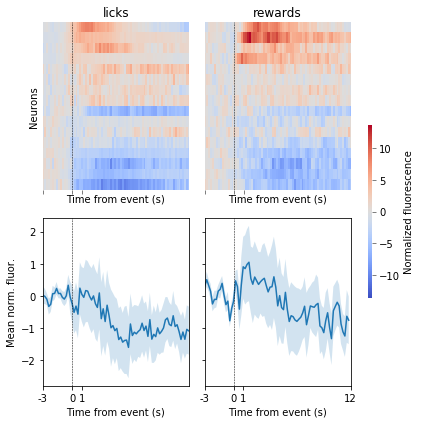

In [27]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

# loop through conditions and plot heatmaps of trial-avged activity
for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
    if flag_plot_reward_line:
        ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from event (s)')
    
        
    ax = axs[1,t]
    sns.tsplot(populationdata[sortresponse, t*window_size:(t+1)*window_size],
               ax=ax)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
    if flag_plot_reward_line:
        ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from event (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)
# fig.savefig(os.path.join(save_dir, 'results', tempstr+'.pdf'), format='pdf')
#fig.savefig(os.path.join(save_dir, dt_string+'_'+clusterkey + '+' + trial_types[0] + '_'+trial_types[1]+'.png'), format='png', dpi=300)

In [9]:
def num_pc_explained_var(explained_var, explained_var_thresh=90):
    cum_sum = 0
    for idx, PC_var in enumerate(explained_var):
        cum_sum += PC_var
        if cum_sum > explained_var_thresh:
            return idx+1

Number of PCs = 16
Number of PCs to keep = 3


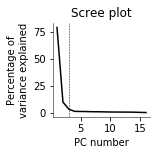

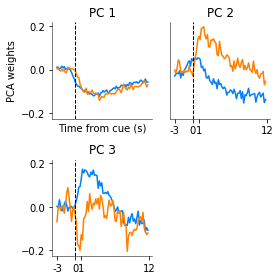

In [10]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

# perform PCA across time
if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=min(populationdata.shape[0],populationdata.shape[1]), whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
#np.save(os.path.join(save_dir, dt_string+'_'+clusterkey+'_' + "transformed_data.npy"),transformed_data)

# eigenvectors
pca_vectors = pca.components_
print 'Number of PCs = %d'%(pca_vectors.shape[0])

# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
x = 100*pca.explained_variance_ratio_ # eigenvalue ratios
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))

# define number of PCs
num_retained_pcs = num_pc_explained_var(x, 90) #np.argmin(xprime)
print 'Number of PCs to keep = %d'%(num_retained_pcs)

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)
#fig.savefig(os.path.join(save_dir, dt_string+'_'+clusterkey+'_' + trial_types[0] + '_'+trial_types[1]+'_scree_plot.png'), format='png', dpi=300)


colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

### plot retained principal components 
numcols = 2.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
        
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.set_title('PC %d'%(pc+1))
    
    # labels
    if pc == 0:
        ax.set_xlabel('Time from cue (s)')
        ax.set_ylabel( 'PCA weights')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

plt.tight_layout()
#fig.savefig(os.path.join(save_dir, dt_string+'_'+clusterkey+'_' +  trial_types[0] + '_'+trial_types[1]+'_PCA.png'), format='png', dpi=300)

## Spectral Clustering

In [11]:
# calculate optimal number of clusters and nearest neighbors using silhouette scores
min_clusters = np.min([max_n_clusters+1, int(populationdata.shape[0])])
possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print 'Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx])

print 'Done with model fitting'

silhouette_dict = {}
silhouette_dict['possible_n_clusters'] = possible_n_clusters
silhouette_dict['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
silhouette_dict['silhouette_scores'] = silhouette_scores
silhouette_dict['shape'] = 'cluster_nn'
#with open(os.path.join(save_dir,dt_string+'_'+ clusterkey+'_' +  'silhouette_scores.pickle'), 'wb') as f:
#    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 3: score = 0.443
Done with numclusters = 2, num nearest neighbors = 5: score = 0.488
Done with numclusters = 2, num nearest neighbors = 10: score = 0.493
Done with numclusters = 3, num nearest neighbors = 3: score = 0.386
Done with numclusters = 3, num nearest neighbors = 5: score = 0.452
Done with numclusters = 3, num nearest neighbors = 10: score = 0.414
Done with numclusters = 4, num nearest neighbors = 3: score = 0.324
Done with numclusters = 4, num nearest neighbors = 5: score = 0.541
Done with numclusters = 4, num nearest neighbors = 10: score = 0.430
Done with numclusters = 5, num nearest neighbors = 3: score = 0.167
Done with numclusters = 5, num nearest neighbors = 5: score = 0.551
Done with numclusters = 5, num nearest neighbors = 10: score = 0.005
Done with numclusters = 6, num nearest neighbors = 3: score = 0.264
Done with numclusters = 6, num nearest neighbors = 5: score = 0.414
Done with numclusters = 6, num nearest neigh

In [12]:
# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_dict['silhouette_scores']==np.nanmax(silhouette_dict['silhouette_scores']))
n_clusters = silhouette_dict['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_dict['possible_n_nearest_neighbors'][temp[1][0]]

print n_clusters, n_nearest_neighbors

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print 'Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp)

# Save this optimal clustering model.
# with open(os.path.join(save_dir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(summarydictdir, dt_string+'_'+ clusterkey+'_' + 'spectral_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

5 5
Number of clusters = 5, average silhouette = 0.551


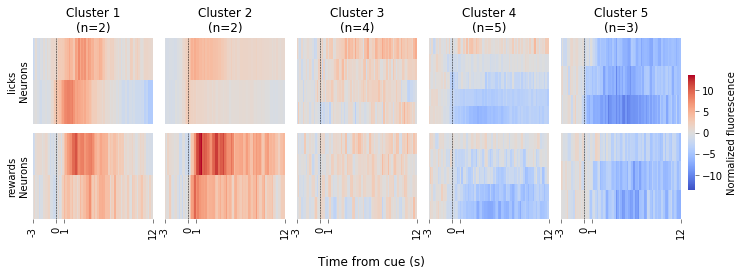

In [13]:

sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
if len(axs.shape) == 1:
    axs = np.expand_dims(axs, axis=0)
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],                                                                                                                                                                                                 
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False) 
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)    
        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        if flag_plot_reward_line:
            axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)                                    

#fig.savefig(os.path.join(save_dir, dt_string+'_'+clusterkey+'_' +  trial_types[0] + '_'+trial_types[1]+'_clusters_spectral_clustering.png'),format='png', dpi=300,bbox_inches='tight')


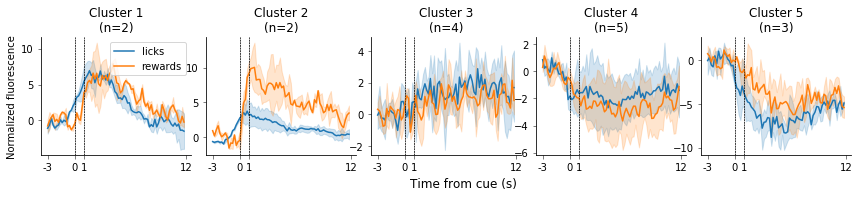

In [14]:

fig, axs = plt.subplots(1,len(uniquelabels),
                        figsize=(2.5*len(uniquelabels),1.3*len(trial_types)))

for c, cluster in enumerate(uniquelabels):

    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.lineplot(x="variable", y="value",data = pd.DataFrame(temp[sortresponse]).melt(),
                    ax = axs[cluster],
                    palette=plt.get_cmap('coolwarm'),label = tempkey,legend = False)
        axs[cluster].grid(False)
        if k==len(trial_types)-1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])
        axs[cluster].tick_params(width=0.5)    
        axs[cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].spines['right'].set_visible(False)
        axs[cluster].spines['top'].set_visible(False)
        if cluster==0:
            axs[cluster].set_ylabel('Normalized fluorescence')
        else:
            axs[cluster].set_ylabel('')
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    axs[0].legend()
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

#fig.savefig(os.path.join(save_dir, dt_string+'_'+ clusterkey+'_' + trial_types[0] + '_'+trial_types[1]+'_clusters_average_spectral_clustering.png'), format='png', dpi=300,bbox_inches='tight')

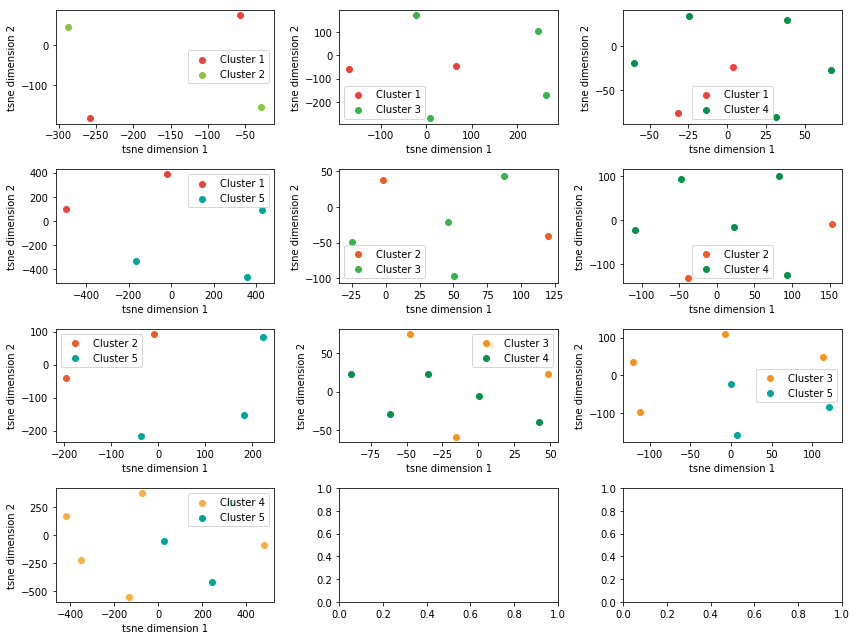

In [15]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        if numrows*numcols==1:
            ax = axs
        else:
            ax = axs[tempsum/numcols,
                     tempsum - tempsum/numcols*numcols]   
        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2+3], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1

        fig.tight_layout()